In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces 
from elastica.external_forces import GravityForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet 
from elastica.timestepper import extend_stepper_interface
from elastica.timestepper import integrate 

from analytical_result import analytical_result

In [15]:
%matplotlib inline
time = 0
class PendulumSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass 

Pendulum_Sim = PendulumSimulator()

# Create Rod 
n_elem = 40
#--------------mGS Unit-----------------
# density = 1200* 1e-6 * 1000000 #mGS
# gravitational_acc = -9.80665e0 * 1e3 /1000000 #mGS
# base_length = 10 #mGS 
# base_radius = 1 #mGS
# E = 1.2e9
#--------------CGS Unit------------------
# density = 2273* 1e-3   #g/cm^3
# gravitational_acc = -9.80665e0 * 1e2  #cm/s^2
# base_length = 0.3 # cm
# base_radius = 0.06 # cm
# E = 1.4e6* 10 # g/(cm*s)
#--------------SI Unit------------------
# density = 1200 * 1000000 #SI
# gravitational_acc = -9.80665e0  /1000000 #SI
# base_length = 10e-3 #SI 
# base_radius = 1e-3 #SI
# E = 1.2e9 #SI
#--------------mmGS Unit------------------
density = 2.273 # mg/mm^3
gravitational_acc = -9.80665e3  #mm/s^2
base_length = 3 #mm 
base_radius = 0.3 #mm
scale_E = 1e-6 # scale down to prevent double-precision float arithmetic issues
scale_E_c = 1e-5
E = 1.4e9 # mg/(mm*s^2)

dl = base_length / n_elem 
# dt = 0.002 * dl 
dt = 1.0e-4
nu = 5 #damping constant
shear_modulus = E / (3.0)

start = np.array([0.0,0.0,0.0])
direction = np.array([0.0, 1.0, 0.0])
normal = np.array([1.0, 0.0, 0.0])
base_area = np.pi * base_radius**2
# base_area = base_radius*np.sqrt(3)/3

origin_force = np.array([0.0, 0.0, 0.0])
end_force = np.array([0.0, 0.0, -1000000.0])
ramp_up_time = 0.15
#------------------ comparison--------------
 
softer_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E*scale_E,
    shear_modulus = shear_modulus*scale_E,
)

stiffer_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus = E*10*scale_E,
    shear_modulus = shear_modulus*10*scale_E,
)
softer_rod_c = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E*scale_E_c,
    shear_modulus = shear_modulus*scale_E_c,
)

stiffer_rod_c = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus = E*10*scale_E_c,
    shear_modulus = shear_modulus*10*scale_E_c,
)

Pendulum_Sim.append(softer_rod)
Pendulum_Sim.append(stiffer_rod)
Pendulum_Sim.append(softer_rod_c)
Pendulum_Sim.append(stiffer_rod_c)

Pendulum_Sim.dampen(softer_rod).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)
Pendulum_Sim.dampen(stiffer_rod).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)
Pendulum_Sim.dampen(softer_rod_c).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)
Pendulum_Sim.dampen(stiffer_rod_c).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)
Pendulum_Sim.constrain(softer_rod).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
)
Pendulum_Sim.constrain(stiffer_rod).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
)
Pendulum_Sim.constrain(softer_rod_c).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
)
Pendulum_Sim.constrain(stiffer_rod_c).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
)
print("One end of the rod is now fixed in place")

# Pendulum_Sim.add_forcing_to(softer_rod).using(
#     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
# )
# Pendulum_Sim.add_forcing_to(stiffer_rod).using(
#     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
# )

Pendulum_Sim.add_forcing_to(softer_rod).using(
    EndpointForces, origin_force, end_force*scale_E, ramp_up_time = ramp_up_time
)
Pendulum_Sim.add_forcing_to(stiffer_rod).using(
    EndpointForces, origin_force, end_force*scale_E, ramp_up_time=ramp_up_time
)
Pendulum_Sim.add_forcing_to(softer_rod_c).using(
    EndpointForces, origin_force, end_force*scale_E_c, ramp_up_time = ramp_up_time
)
Pendulum_Sim.add_forcing_to(stiffer_rod_c).using(
    EndpointForces, origin_force, end_force*scale_E_c, ramp_up_time=ramp_up_time
)
print("Forces added to the rod")

Pendulum_Sim.finalize()
print("System finalized")

def run_and_update_plot(simulator, dt, start_time, stop_time, ax):
    timestepper = PositionVerlet()
    do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

    n_steps = int((stop_time - start_time)/ dt)
    time = start_time
    for i in range(n_steps):
        time = do_step(timestepper, stages_and_updates, simulator, time, dt)
    plot_pendulum_dynamic(softer_rod, stiffer_rod, softer_rod_c, stiffer_rod_c, time, ax)
    return time 

def plot_pendulum_dynamic(rod1,rod2,rod3,rod4,time, ax):
    analytical_shearable_position = analytical_result(
        softer_rod, end_force*scale_E, shearing=False
    )
    analytical_unshearable_position = analytical_result(
        stiffer_rod, end_force*scale_E, shearing = False
    )
    ax.clear()
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        analytical_shearable_position[0],
        analytical_shearable_position[1],
        "k--",
        # label = "Timoshenko"
        label = "Euler-Bernoulli"
    )
    ax.plot(
        analytical_unshearable_position[0],
        analytical_unshearable_position[1],
        "k-",
        label="Euler-Bernoulli"
    )
    ax.plot(
        rod1.position_collection[1,:],
        rod1.position_collection[2,:],
        "r-",
        label = "softer rod 1e-6",
    )
    ax.plot(
        rod2.position_collection[1,:],
        rod2.position_collection[2,:],
        'b-',
        label = "stiffer rod 1e-6"
    )
    ax.plot(
        rod3.position_collection[1,:],
        rod3.position_collection[2,:],
        'r--',
        label = "softer rod 1e-5"
    )
    ax.plot(
        rod4.position_collection[1,:],
        rod4.position_collection[2,:],
        'b--',
        label = "stiffer rod 1e-5"
    )
    ax.legend(prop={"size":12}, loc="lower left")
    ax.set_ylabel("Y Position (mm)", fontsize=12)
    ax.set_xlabel("X Position (mm)", fontsize=12)
    ax.set_title(f"Simulation Time: {time:.2f} seconds")
    ax.set_ylim([-3,0.01])
    ax.set_xlim([-0.1,3.1])

One end of the rod is now fixed in place
Forces added to the rod
System finalized


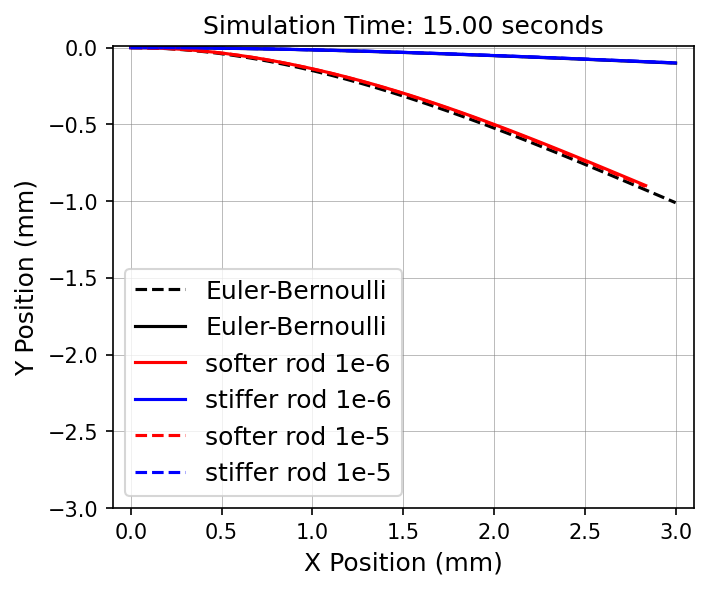

In [16]:
%matplotlib inline
evolve_for_time = 15.0
update_interval = 1.0e-1 

import cv2,os
# update the plot every 0.1 second
fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
ax = fig.add_subplot(111)

plt.savefig('Pendulum.jpg')
video_name = 'Pendulum.mp4'
frame = cv2.imread('Pendulum.jpg')
height, width, layers = frame.shape
fourcc = cv2.VideoWriter_fourcc('M','P','4','V') # 解码器
video = cv2.VideoWriter(video_name,fourcc,10,(width,height))
first_interval_time = update_interval + time 
last_interval_time = time + evolve_for_time
for stop_time in np.arange(
    first_interval_time, last_interval_time+dt, update_interval
):
    time = run_and_update_plot(Pendulum_Sim, dt, time, stop_time, ax)
    display.clear_output(wait=True)
    image = plt.gcf()
    display.display(image)
    plt.savefig('Pendulum.jpg')
    video.write(cv2.imread("Pendulum.jpg"))
plt.close()
cv2.destroyAllWindows()
video.release()